Dataset Link- https://www.kaggle.com/msambare/fer2013

In [1]:
import tensorflow as tf                                                                     # Importing all the required Libraries
from tensorflow import keras
from tensorflow.keras.models import Sequential                                                            
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np 
import cv2
import os

import warnings                                                                                # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
training_gen=ImageDataGenerator(rescale=1./255)                                                # Creating Image generators, for all train, validation, and test set
testing_gen=ImageDataGenerator(rescale=1./255)

In [3]:
train_gen=training_gen.flow_from_directory('C:\\Users\\Arko\\Desktop\\All projects\\cnn\\train',                                    # Creating  Training Dataset 
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')

test_gen=testing_gen.flow_from_directory('C:\\Users\\Arko\\Desktop\\All projects\\cnn\\test',                                        # Creating Test Set
                                           target_size=(48,48),  
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
print(train_gen.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


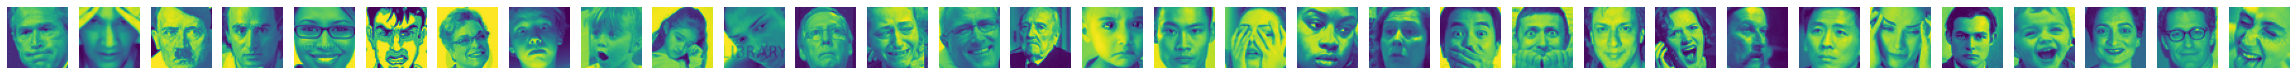

angry   sad   sad   fear   happy   angry   happy   surprise   surprise   sad   sad   fear   sad   happy   sad   sad   neutral   fear   sad   sad   surprise   fear   happy   angry   surprise   sad   sad   neutral   happy   happy   happy   disgust   

In [5]:
imgs,lables=next(train_gen)                                                                   # Extracting next batch to plot it, this batch of photos are selected randomly
list_of_keys=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']                  # list of Classes
def plotImages(images_arr):
  fig, axes= plt.subplots(1,32,figsize=(32,2))
  axes= axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
plotImages(imgs)
for i in lables[:32]:                                                                             # Printing the lables below the respective image
  for num, j in enumerate(i):
    if j==1:
      print(list_of_keys[num], end='   ')                                                         # Labelling seems to be spot on     
num+=1

In [6]:
# from keras.optimizers import Adam,SGD,RMSprop

no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(256,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))



opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [7]:
model.save("model.h5")

In [8]:
checkpoint = ModelCheckpoint('./my_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')          # Adding various Call Backs Like Early stopping to prevent overfitting and Decay Learning Rate to prevent Overshooting

early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)
decay_lr= ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=3,
                           verbose=1,
                           min_delta=0.0001)
callbacks=[early_stopping,checkpoint,decay_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [9]:
history = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=40,
                                validation_data = test_gen,
                                validation_steps = test_gen.n//test_gen.batch_size,
                                callbacks=callbacks
                                )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
897/897 [==============================] - 610s 680ms/step - loss: 1.7212 - accuracy: 0.3384 - val_loss: 1.4901 - val_accuracy: 0.4325
Epoch 2/40
897/897 [==============================] - 666s 742ms/step - loss: 1.3724 - accuracy: 0.4747 - val_loss: 1.6062 - val_accuracy: 0.4216
Epoch 3/40
897/897 [==============================] - 660s 736ms/step - loss: 1.2438 - accuracy: 0.5283 - val_loss: 1.2289 - val_accuracy: 0.5268
Epoch 4/40
897/897 [==============================] - 678s 756ms/step - loss: 1.1773 - accuracy: 0.5532 - val_loss: 1.5168 - val_accuracy: 0.4284
Epoch 5/40
897/897 [==============================] - 660s 736ms/step - loss: 1.1229 - accuracy: 0.5757 - val_loss: 1.2704 - val_accuracy: 0.5086
Epoch 6/40
897/897 [==============================] - 667s 744ms/step - loss: 1.0625 - accuracy: 0.5963 - val_loss: 1.1904 - val_accuracy: 0.5349
Epoch 7/40
897/897 [============================

* Our best model managed to obtain a accuracy of approximately 79.8% and val_accuracy of 65.75% on the dataset by running 50 epochs.which is quite good.
* At each epoch, Keras checks if our model performed better than the models of the previous epochs.

In [10]:
predictions=model.predict(test_gen)                                                                               # Predicting For Test Set
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)                                  # Printing Confution Matrix  
cm

array([[ 419,   13,   59,   68,  148,  230,   21],
       [  16,   60,    3,    7,    9,   14,    2],
       [  80,    4,  287,   45,  159,  339,  110],
       [  25,    1,   17, 1438,  142,  117,   34],
       [  48,    3,   22,   76,  794,  280,   10],
       [  74,    1,   32,   54,  250,  819,   17],
       [  15,    4,   37,   49,   53,   41,  632]], dtype=int64)

In [11]:
aoc=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=test_gen.classes)                                    # Accuracy Score of Our Model
aoc    

0.6198105321816662

In [20]:
model.save('CNN_model.h5')   

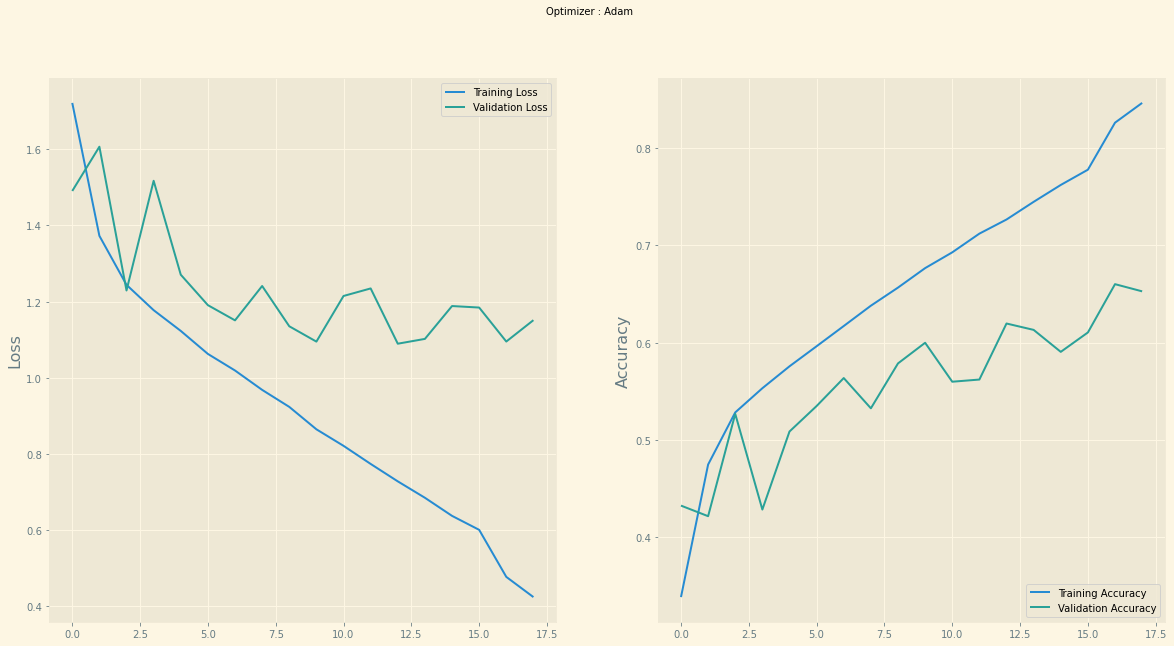

In [21]:
#Plotting Accuracy & Loss
plt.style.use('Solarize_Light2')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

<Figure size 432x288 with 0 Axes>

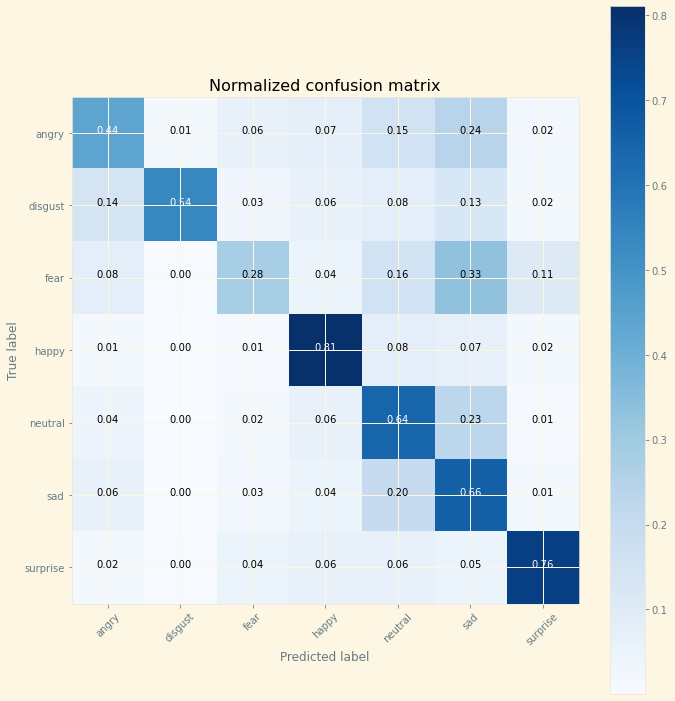

In [22]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=test_gen)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_gen.classes
class_names = test_gen.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# Real-time predictions


# import tensorflow as tf
from tensorflow.keras.models import load_model
from time import sleep
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import tensorflow as tf

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') # Face Detection
classifier =load_model("CNN_model.h5")  #Load model

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']  # Emotion that will be predicted

cap = cv2.VideoCapture(0)  ## Opening webcam



while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)  ##Face Cropping for prediction



        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0) ## reshaping the cropped face image for prediction

            prediction = classifier.predict(roi)[0]   #Prediction
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)   # Text Adding
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Conclusion
1. Our model is giving an accuracy of 81% and is robust in that it works well even in a dim light environment.
2. The application is able to detect face location and predict the right expression while checking it on a local webcam.
3. The front-end of the model was made using streamlit for webapp and running well on local webapp link.
4. Finally, we successfully deployed the Streamlit WebApp on Heroku and Streamlit share that runs on a web server.
5. And I believe that through this model teachers can understand the students' perception during online classes and change the way of teaching if needed by understanding the students’ motive.